In [1]:
%cd /Users/gwg/local/dmcm
%matplotlib inline

import csv
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from   sklearn.decomposition.pca import PCA

import torch

from   data import GTExConfig, GTExDataset
from   models import JMVAE
import plotutils

/Users/gwg/local/dmcm


In [2]:
cfg     = GTExConfig()
dataset = GTExDataset(cfg)

In [65]:
fname = 'experiments/20180621_principled_avg/gtex_dim-2_lr-1e-05_epochs-3000'
state = torch.load('%s/model.pt' % fname, map_location={'cuda:0': 'cpu'})
model = JMVAE(cfg)
model.eval()
model.load_state_dict(state)

Text(0.5,1,'Test KLD error')

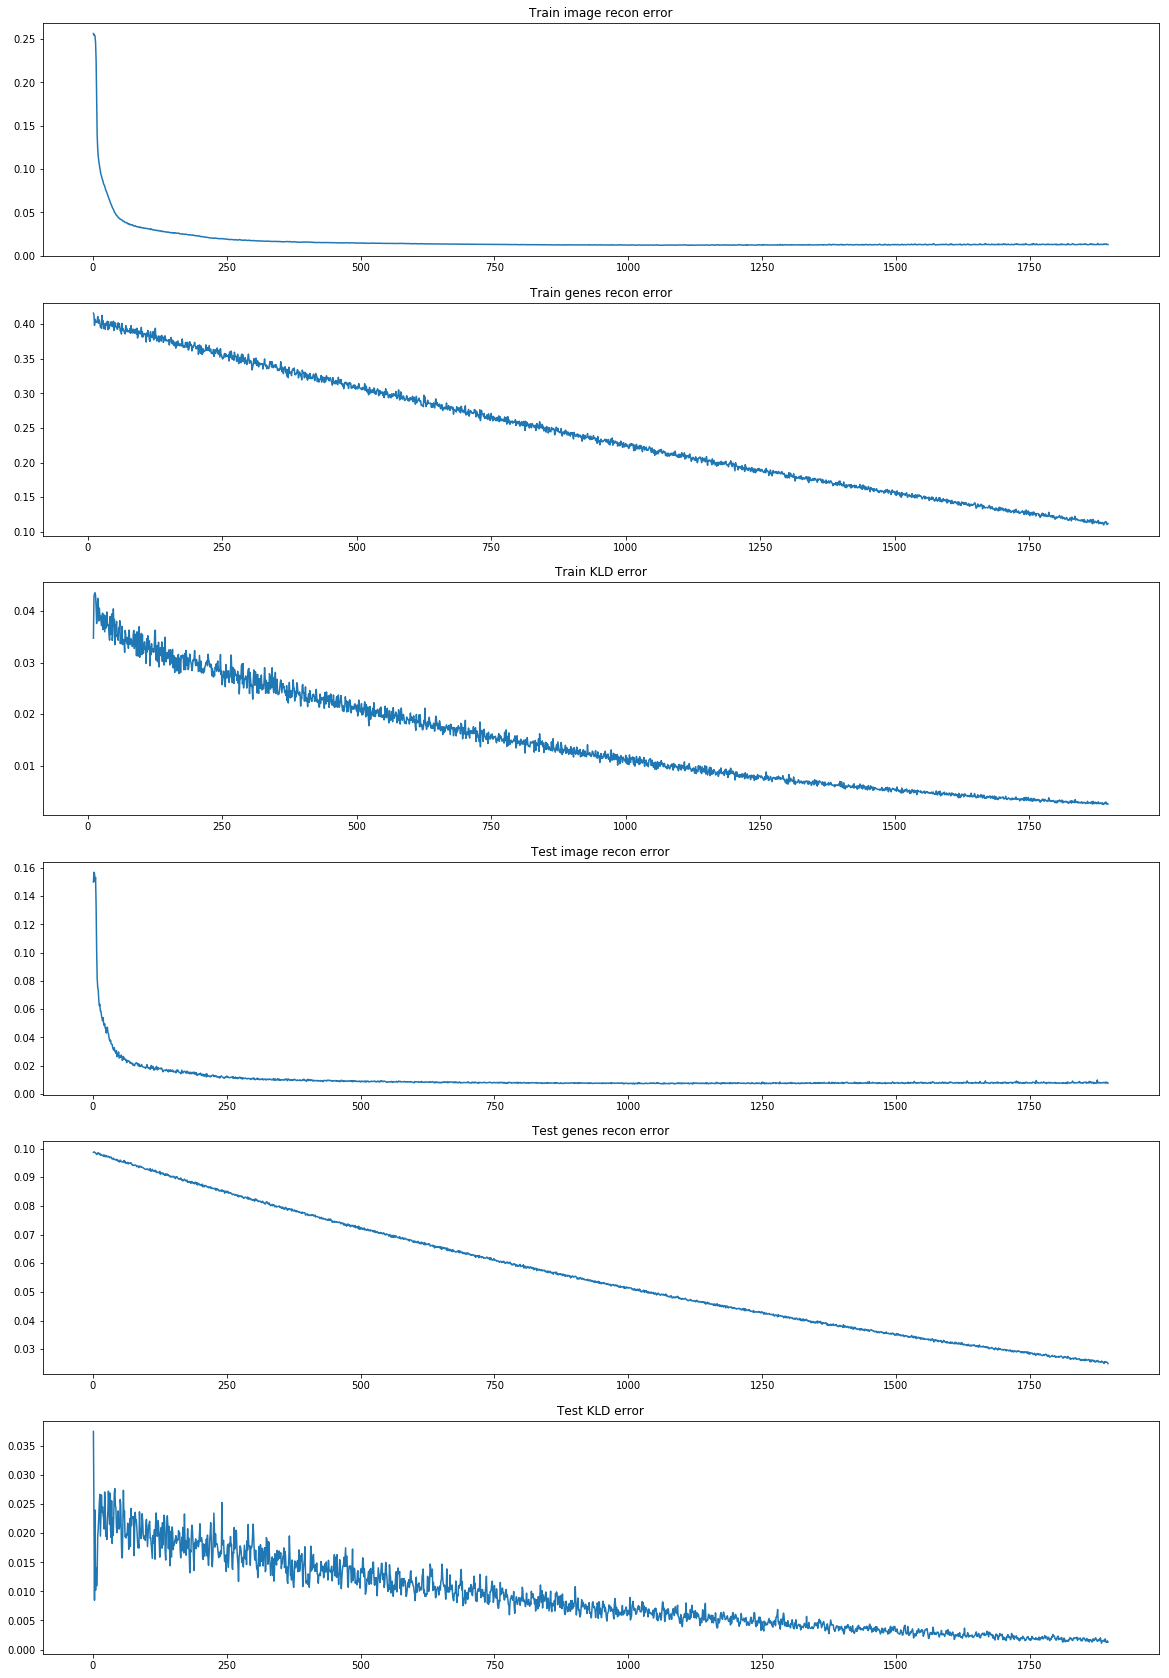

In [66]:
fpath   = '%s/out.txt' % fname
data    = np.array(plotutils.parse_jmvae_file(fpath))

x         = data[:, 0]
tr_recon1 = data[:, 1]
tr_recon2 = data[:, 2]
tr_kld    = data[:, 3]
te_recon1 = data[:, 4]
te_recon2 = data[:, 5]
te_kld    = data[:, 6]

fig, axs = plt.subplots(6, 1, figsize=(20, 30))

axs[0].plot(x, tr_recon1)
axs[0].set_title('Train image recon error')

axs[1].plot(x[10:], tr_recon2[10:])
axs[1].set_title('Train genes recon error')

axs[2].plot(x[10:], tr_kld[10:])
axs[2].set_title('Train KLD error')

axs[3].plot(x, te_recon1)
axs[3].set_title('Test image recon error')

axs[4].plot(x, te_recon2)
axs[4].set_title('Test genes recon error')

axs[5].plot(x, te_kld)
axs[5].set_title('Test KLD error')

In [48]:
N_SAMPLES   = 2221

with torch.no_grad():
    X_emb = torch.Tensor(N_SAMPLES, cfg.LATENT_DIM)
    for i in range(N_SAMPLES):
        if i % 250 == 0: print(i)
        x1, x2 = dataset[i]
        x1 = x1.unsqueeze(0)
        x2 = x2.unsqueeze(0)
        _, _, mu, _ = model.forward([x1, x2])
        X_emb[i] = mu

X_emb = X_emb.numpy()

0
250
500
750
1000
1250
1500
1750
2000


Plotting, compression method = None


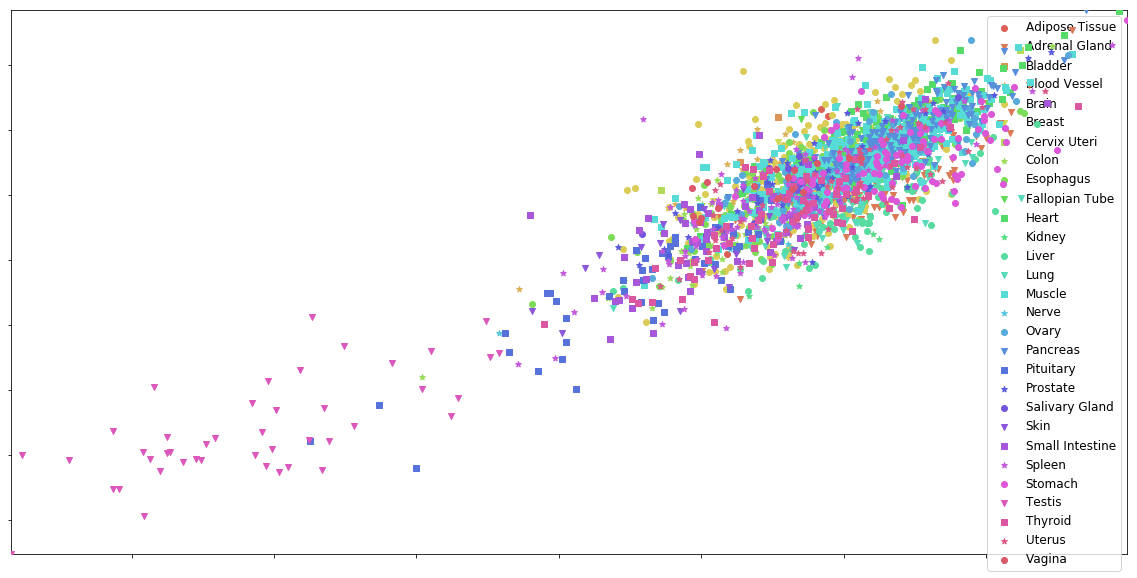

In [50]:
comp_mode = 'pca' if cfg.LATENT_DIM > 2 else None
print('Plotting, compression method = %s' % comp_mode)
plotutils.plot_both_embeddings([X_emb], dataset=dataset, comp_mode=comp_mode)
# print(X_emb[:, 0])
# print(X_emb[:, 1])
# plt.scatter(X_emb[:, 0], X_emb[:, 1])

In [80]:
from torchvision.utils import save_image

images = torch.Tensor(128, 3, 224, 224)
genes = torch.Tensor(128, 18659)

for i in range(128):
    img, gen = dataset[i]
    images[i] = img
    genes[i] = gen

image_batch = torch.Tensor(128, 3, 224, 224)
gene_batch = torch.Tensor(128, 18659)

for i in range(128):
    image_orig, gene = dataset[i]
    image_batch[i] = image_orig
    gene_batch[i] = gene

z, _, _, _ = model.genes_net.forward(gene_batch)
image_recon = model.image_net.decode(z)
N = 64
image_recon = image_recon[:N]
image_recon = image_recon.view(N, cfg.N_CHANNELS, cfg.IMG_SIZE, cfg.IMG_SIZE)

image_batch = image_batch[:N]
image_batch = image_batch.view(N, cfg.N_CHANNELS, cfg.IMG_SIZE, cfg.IMG_SIZE)
save_image(image_batch,  '/Users/gwg/Desktop/jmvae_cross-mode/image_orig.png')
save_image(image_recon, '/Users/gwg/Desktop/jmvae_cross-mode/image_recon.png')

model.eval()
with torch.no_grad():
    model.forward([images, genes])
    
    z = torch.randn(128, 2)
    x1_recon = model.image_net.decode(z)
    print(x1_recon.shape)
    N = 64
    x1_recon = x1_recon[:N]
    x1_recon = x1_recon.view(N, cfg.N_CHANNELS, cfg.IMG_SIZE, cfg.IMG_SIZE)
    fname    = '/Users/gwg/Desktop/jmvae_fantasy/samples.png'
    save_image(x1_recon, fname)

torch.Size([128, 3, 224, 224])
